In [1]:
import pandas as pd
import numpy as np
import matplotlib as plot
import os
import glob
import dask.dataframe as dd
chunksize=2**10
import json

In [2]:
base_raw_data_path = os.path.join('..', 'virtual_machine2')
raw_data_paths = {
    'fiber_experimental': glob.glob(f"{os.path.join(base_raw_data_path, 'fiber_experiment')}*"),
    'fiber_ethernet_control': glob.glob(f"{os.path.join(base_raw_data_path, 'fiber_control')}*"),
    'fiber_one_port_control': glob.glob(f"{os.path.join(base_raw_data_path, 'fiber_shared_port')}*"),
    'fiber_shared_host_port_control': glob.glob(f"{os.path.join(base_raw_data_path, 'host_port')}*")

}

# Helpers

### File Reading Helpers

In [3]:
def flattened_glob(paths, pattern):
    """
    For a list of paths, returns a 1D list of matching globs
    """
    return [j for i in [glob.glob(f'{os.path.join(path, pattern)}') for path in paths] for j in i]

def get_dd_of_paths(base_path, read_func, test_type):
    """just to make one liner more readable"""
    return dd.from_pandas( 
                        pd.Series().append([
                            pd.Series([x for path in flattened_glob(base_path, test_type) for x in read_func(path) ])
                            ]),
                        chunksize=chunksize
                      )
def ping_to_series(filename):
    measurements = []
    with open(filename, 'r') as f:
        for line in f.readlines()[1:-4]:
            measurements.append(line[line.find('time=')+5:-1])
    measurements_float = [round(float(msrd[:-3])*1e-3, 8)  if msrd.find('ms') > 0 else float(msrd[:-2]) for msrd in measurements]
    return pd.Series(measurements_float)


In [4]:
test_path = glob.glob(os.path.join(raw_data_paths['fiber_experimental'][0], '*.json'))[0]
test_path

'../virtual_machine2/fiber_experiment_0/unidirectional_throughput_test1.json'

### Plotting

In [5]:
def make_plot(df, xlabel, ylabel):
    plt.rcParams.update({'font.size': 22})
    f = df.plot(figsize=(50,25), fontsize=40, lw=10, xlabel=xlabel, ylabel=ylabel, use_index=True)
    f.set_ylabel(ylabel, fontdict={'fontsize': 45})
    f.set_xlabel(xlabel, fontdict={'fontsize': 45})
    f.legend(loc=4, fontsize=40)
    return f

def make_plot_grouped(df, xlabel, ylabel, batch=20):
    plt.rcParams.update({'font.size': 22})
    f = df.groupby(np.arange(len(df))//batch).mean().plot(figsize=(50,25), lw=10, fontsize=40, xlabel=xlabel, ylabel=ylabel, use_index=True)
    f.set_ylabel(ylabel, fontdict={'fontsize': 45})
    f.set_xlabel(xlabel, fontdict={'fontsize': 45})
    f.legend(loc=4, fontsize=40)
    return f

### DataFrame Helpers

In [6]:
def get_trial(df, row, col):
    return df.loc[row, col].compute().dropna().reset_index(drop=True)

def search_columns(df, term):
    return df[df.columns.map(lambda x: x if term in x else np.nan).dropna()]

def average(df):
    return pd.DataFrame({
        **{col: [get_trial(df, setup, col).mean() for setup in raw_data_paths.keys()]
        for col in df.columns},
    'setup': list(raw_data_paths.keys())
    }).set_index('setup')

def std_dev(df):
    return pd.DataFrame({
        **{col: [get_trial(df, setup, col).std() for setup in raw_data_paths.keys()]
        for col in df.columns},
    'setup': list(raw_data_paths.keys())
    }).set_index('setup')

### Data Fetching

In [7]:
def get_fields(data_dict):
    return [flattened for datum in data_dict['intervals'] for flattened in datum['streams']][0]

def get_field_from_samples(data_dict, field):
    return [flattened[field] if field in flattened else np.nan for datum in data_dict['intervals'][:-2] for flattened in datum['streams']]

def get_bps(data_dict):
    return get_field_from_samples(data_dict, 'bits_per_second')

def get_err(data_dict):
    return get_field_from_samples(data_dict, 'retransmits')

def read_data(file_path, field):
    with open(file_path, 'r') as f:
        x = get_field_from_samples(json.loads('\n'.join(f.readlines())), field)
    return x

def read_fields(file_path):
    with open(file_path, 'r') as f:
        x = json.loads('\n'.join(f.readlines()))
    return x['intervals'][0]['streams'][0].keys()

def read_bps(file_path):
    return read_data(file_path, 'bits_per_second')

def read_retransmits(file_path):
    return read_data(file_path, 'retransmits')

def read_bytes_sent(file_path):
    return read_data(file_path, 'bytes')

def read_err(file_path):
    return [retransmits/bytes_sent for (retransmits, bytes_sent) in zip(read_data(file_path, 'retransmits'),read_data(file_path, 'bytes'))]


In [8]:
read_fields(test_path)

dict_keys(['socket', 'start', 'end', 'seconds', 'bytes', 'bits_per_second', 'retransmits', 'snd_cwnd', 'snd_wnd', 'rtt', 'rttvar', 'pmtu', 'omitted', 'sender'])

# Latency and Throughput

In [9]:
latency_throughput_data = pd.DataFrame({
    field: {
        'bidirectional_throughput': dd.from_pandas(pd.Series(), chunksize=chunksize).append(
                                        get_dd_of_paths(value, read_bps, 'bidirectional_throughput*')
                                    ).reset_index(drop=True),
        'parallel_throughput':dd.from_pandas(pd.Series(), chunksize=chunksize).append(
                                        get_dd_of_paths(value, read_bps, 'parallel_throughput*')
                                    ).reset_index(drop=True),
        'unidirectional_latency':dd.from_pandas(pd.Series(), chunksize=chunksize).append(
                                        get_dd_of_paths(value, ping_to_series, '*latency*')
                                    ).reset_index(drop=True),
        'unidirectional_throughput':dd.from_pandas(pd.Series(), chunksize=chunksize).append(
                                        get_dd_of_paths(value, read_bps, 'unidirectional_throughput*')
                                    ).reset_index(drop=True),
    }
    
    for field, value in raw_data_paths.items()
}).T

/tmp/ipykernel_13471/4209506058.py:3: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  'bidirectional_throughput': dd.from_pandas(pd.Series(), chunksize=chunksize).append(
/tmp/ipykernel_13471/3417018491.py:10: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  pd.Series().append([
/tmp/ipykernel_13471/4209506058.py:6: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  'parallel_throughput':dd.from_pandas(pd.Series(), chunksize=chunksize).append(
/tmp/ipykernel_13471/3417018491.py:10: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this 

In [10]:
latency_throughput_data

,bidirectional_throughput,parallel_throughput,unidirectional_latency,unidirectional_throughput
fiber_experimental,"(1246247631.945711, 944011046.971661, 94139312...","(703054844.369832, 933026599.3582565, 93612750...","(0.000659, 0.00106, 0.000943, 0.00132, 0.001, ...","(961140122.2134006, 1019721907.4373906, 943397..."
fiber_ethernet_control,"(1213762861.0278971, 944691458.527399, 8380227...","(826535275.6605222, 937433560.4909828, 9358503...","(0.000679, 0.00118, 0.00131, 0.00142, 0.00145,...","(1047456669.6454427, 1027228960.7010505, 94339..."
fiber_one_port_control,"(2655804576.978435, 2763035145.85083, 27131491...","(1101416025.7250416, 1625176868.063543, 154587...","(0.000487, 0.00085, 0.000946, 0.000964, 0.0009...","(1781394201.0304463, 2897132508.292256, 275151..."
fiber_shared_host_port_control,"(2950847345.9044375, 2829710914.8155017, 27443...","(1433361686.5099332, 1602937943.0128477, 13009...","(0.00044, 0.000955, 0.00111, 0.00114, 0.00117,...","(1240804908.2718258, 2614965837.824568, 274395..."


In [11]:
get_trial(latency_throughput_data, 'fiber_experimental', 'bidirectional_throughput')[:-1000].std()

24459114.16955679

In [12]:
std_dev(latency_throughput_data).to_csv('./results/latency_throughput_average_stddev.csv')

In [13]:
latency_throughput_avg = average(latency_throughput_data)
latency_throughput_avg.to_csv('./results/latency_throughput_averages.csv')

<AxesSubplot:xlabel='Experimental Type', ylabel='Throughput (Gbps)'>

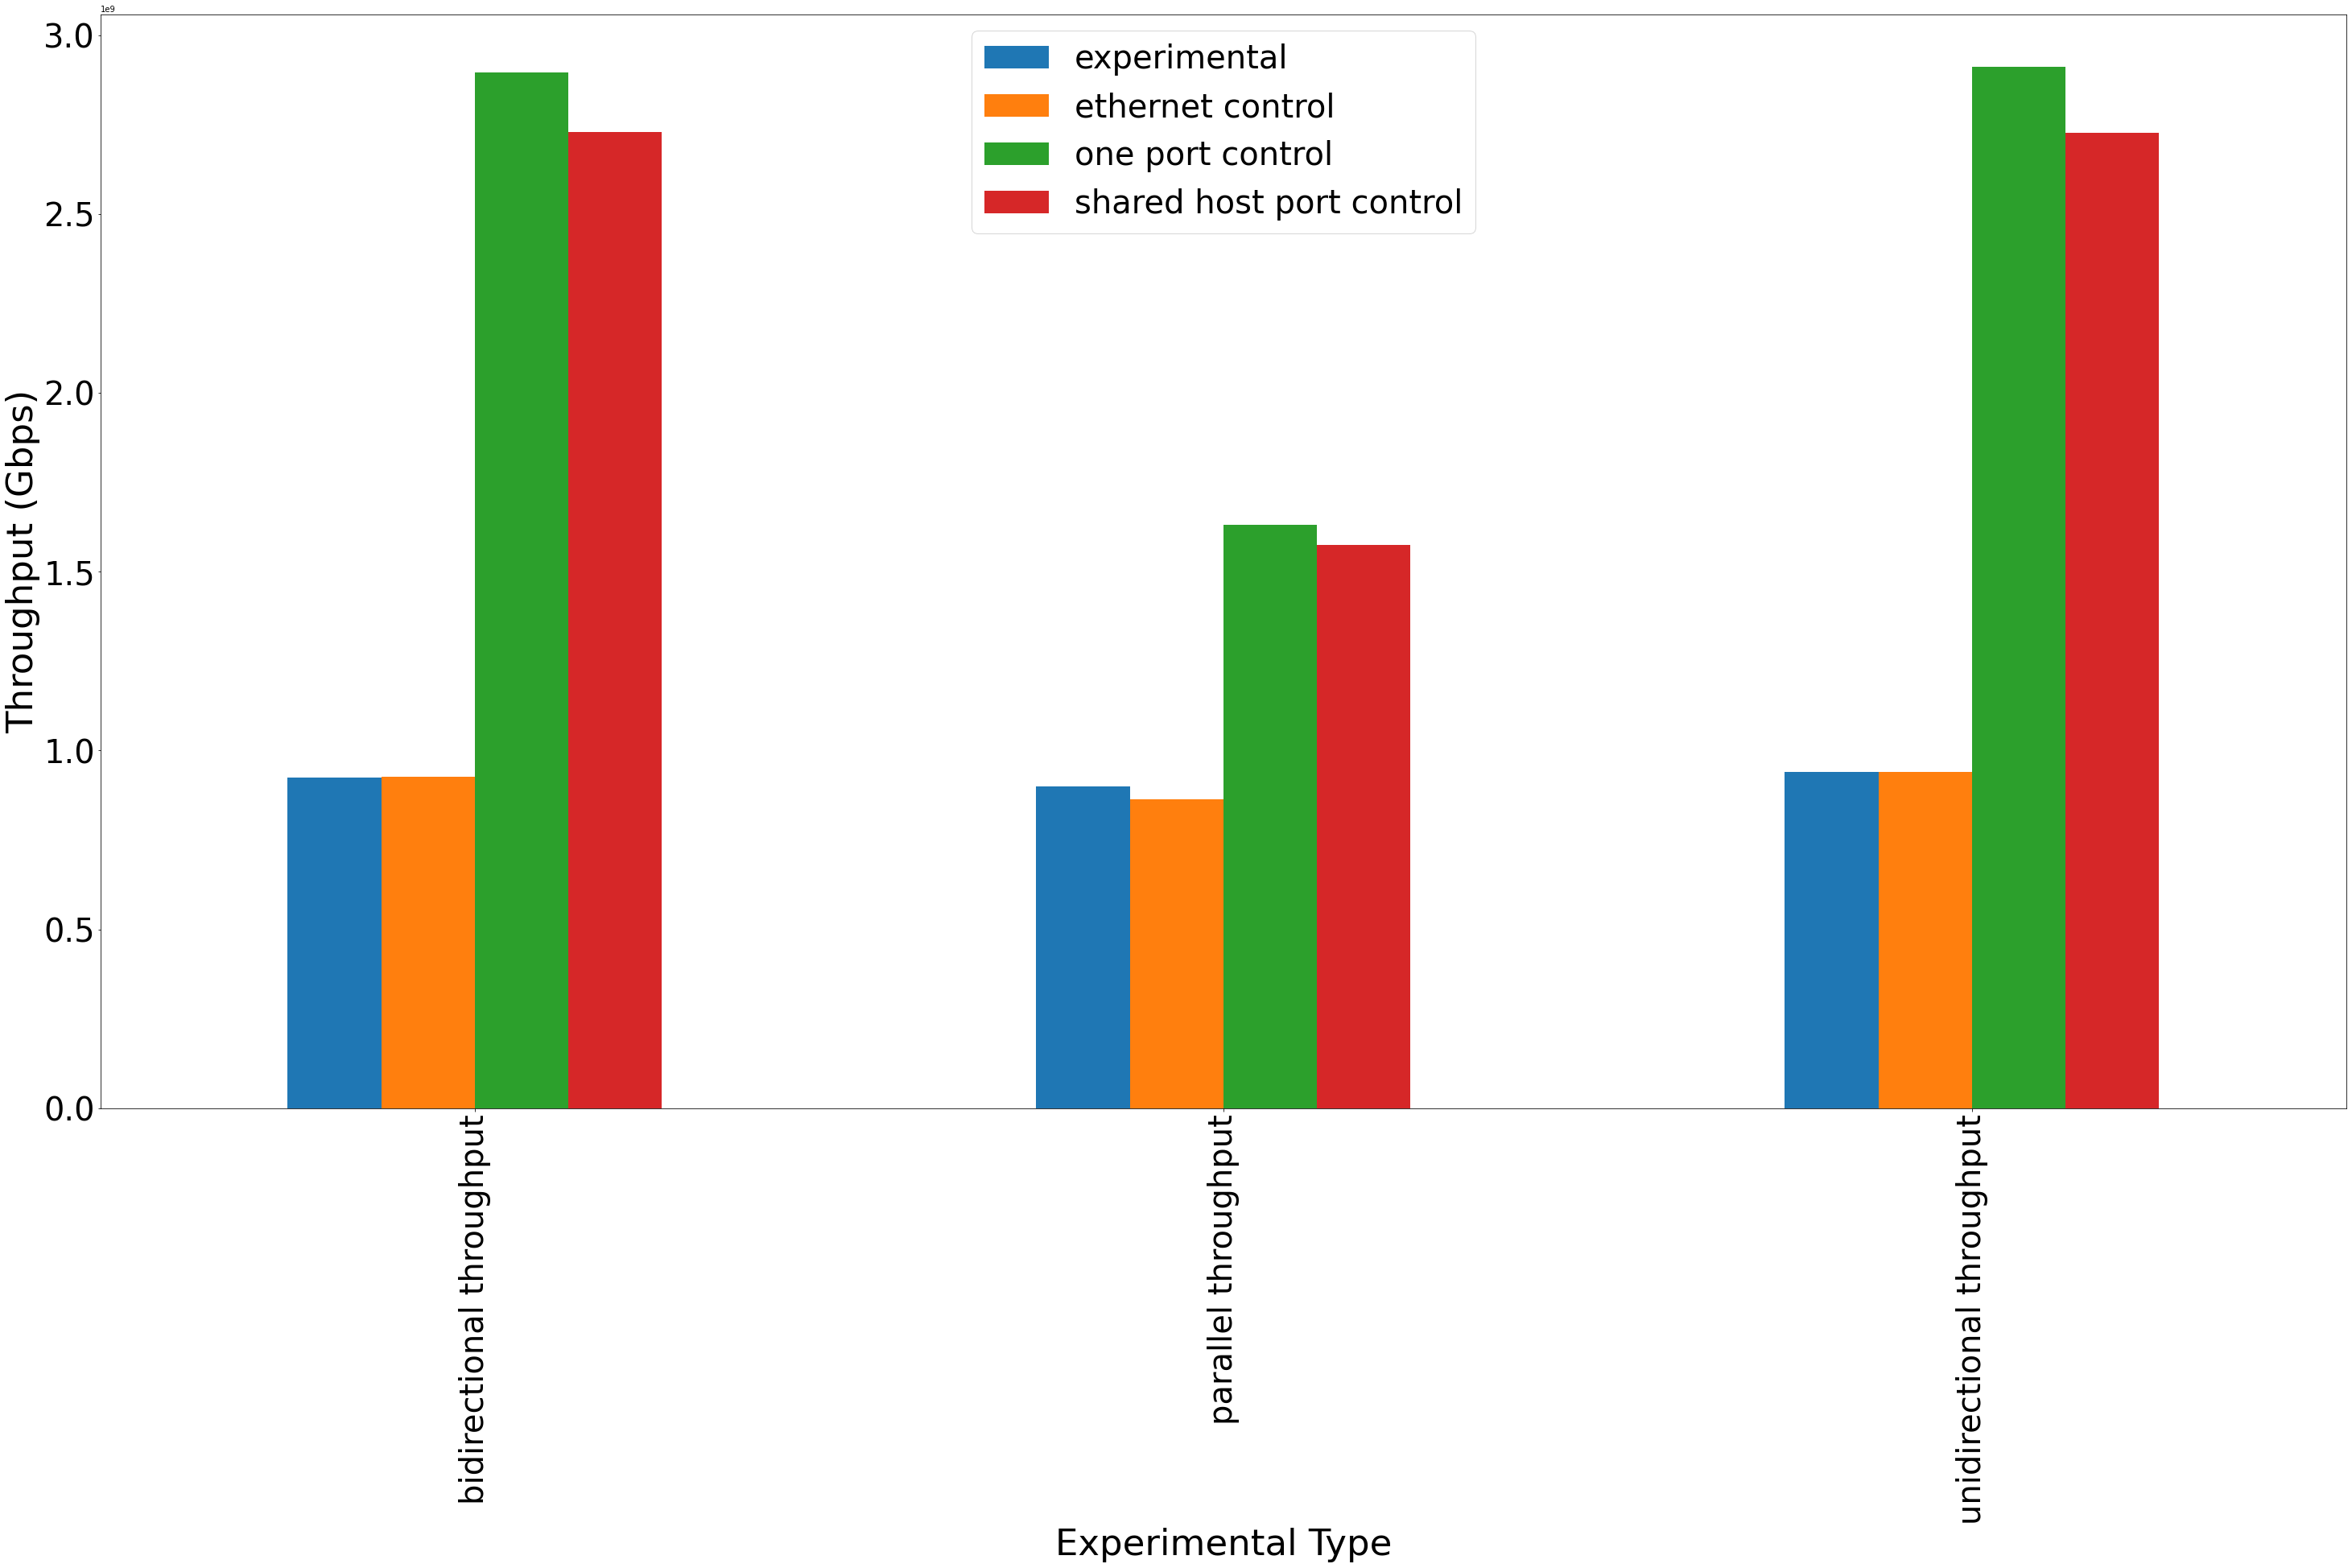

In [14]:
f = search_columns(latency_throughput_avg, 'throughput').T.rename(lambda x: x.replace('_', ' ').replace('fiber ', ''), axis=1).rename(lambda x: x.replace('_', ' '), axis=0).plot(figsize=(50,25), lw=10, fontsize=40, xlabel='Experimental Setup', ylabel="Throughput (Gbps)", kind='bar', use_index=True)
f.set_ylabel('Throughput (Gbps)', fontdict={'fontsize': 45})
f.set_xlabel('Experimental Type', fontdict={'fontsize': 45})
f.legend(loc=0, fontsize=40)
f



<AxesSubplot:xlabel='Experimental Type', ylabel='Latency (s)'>

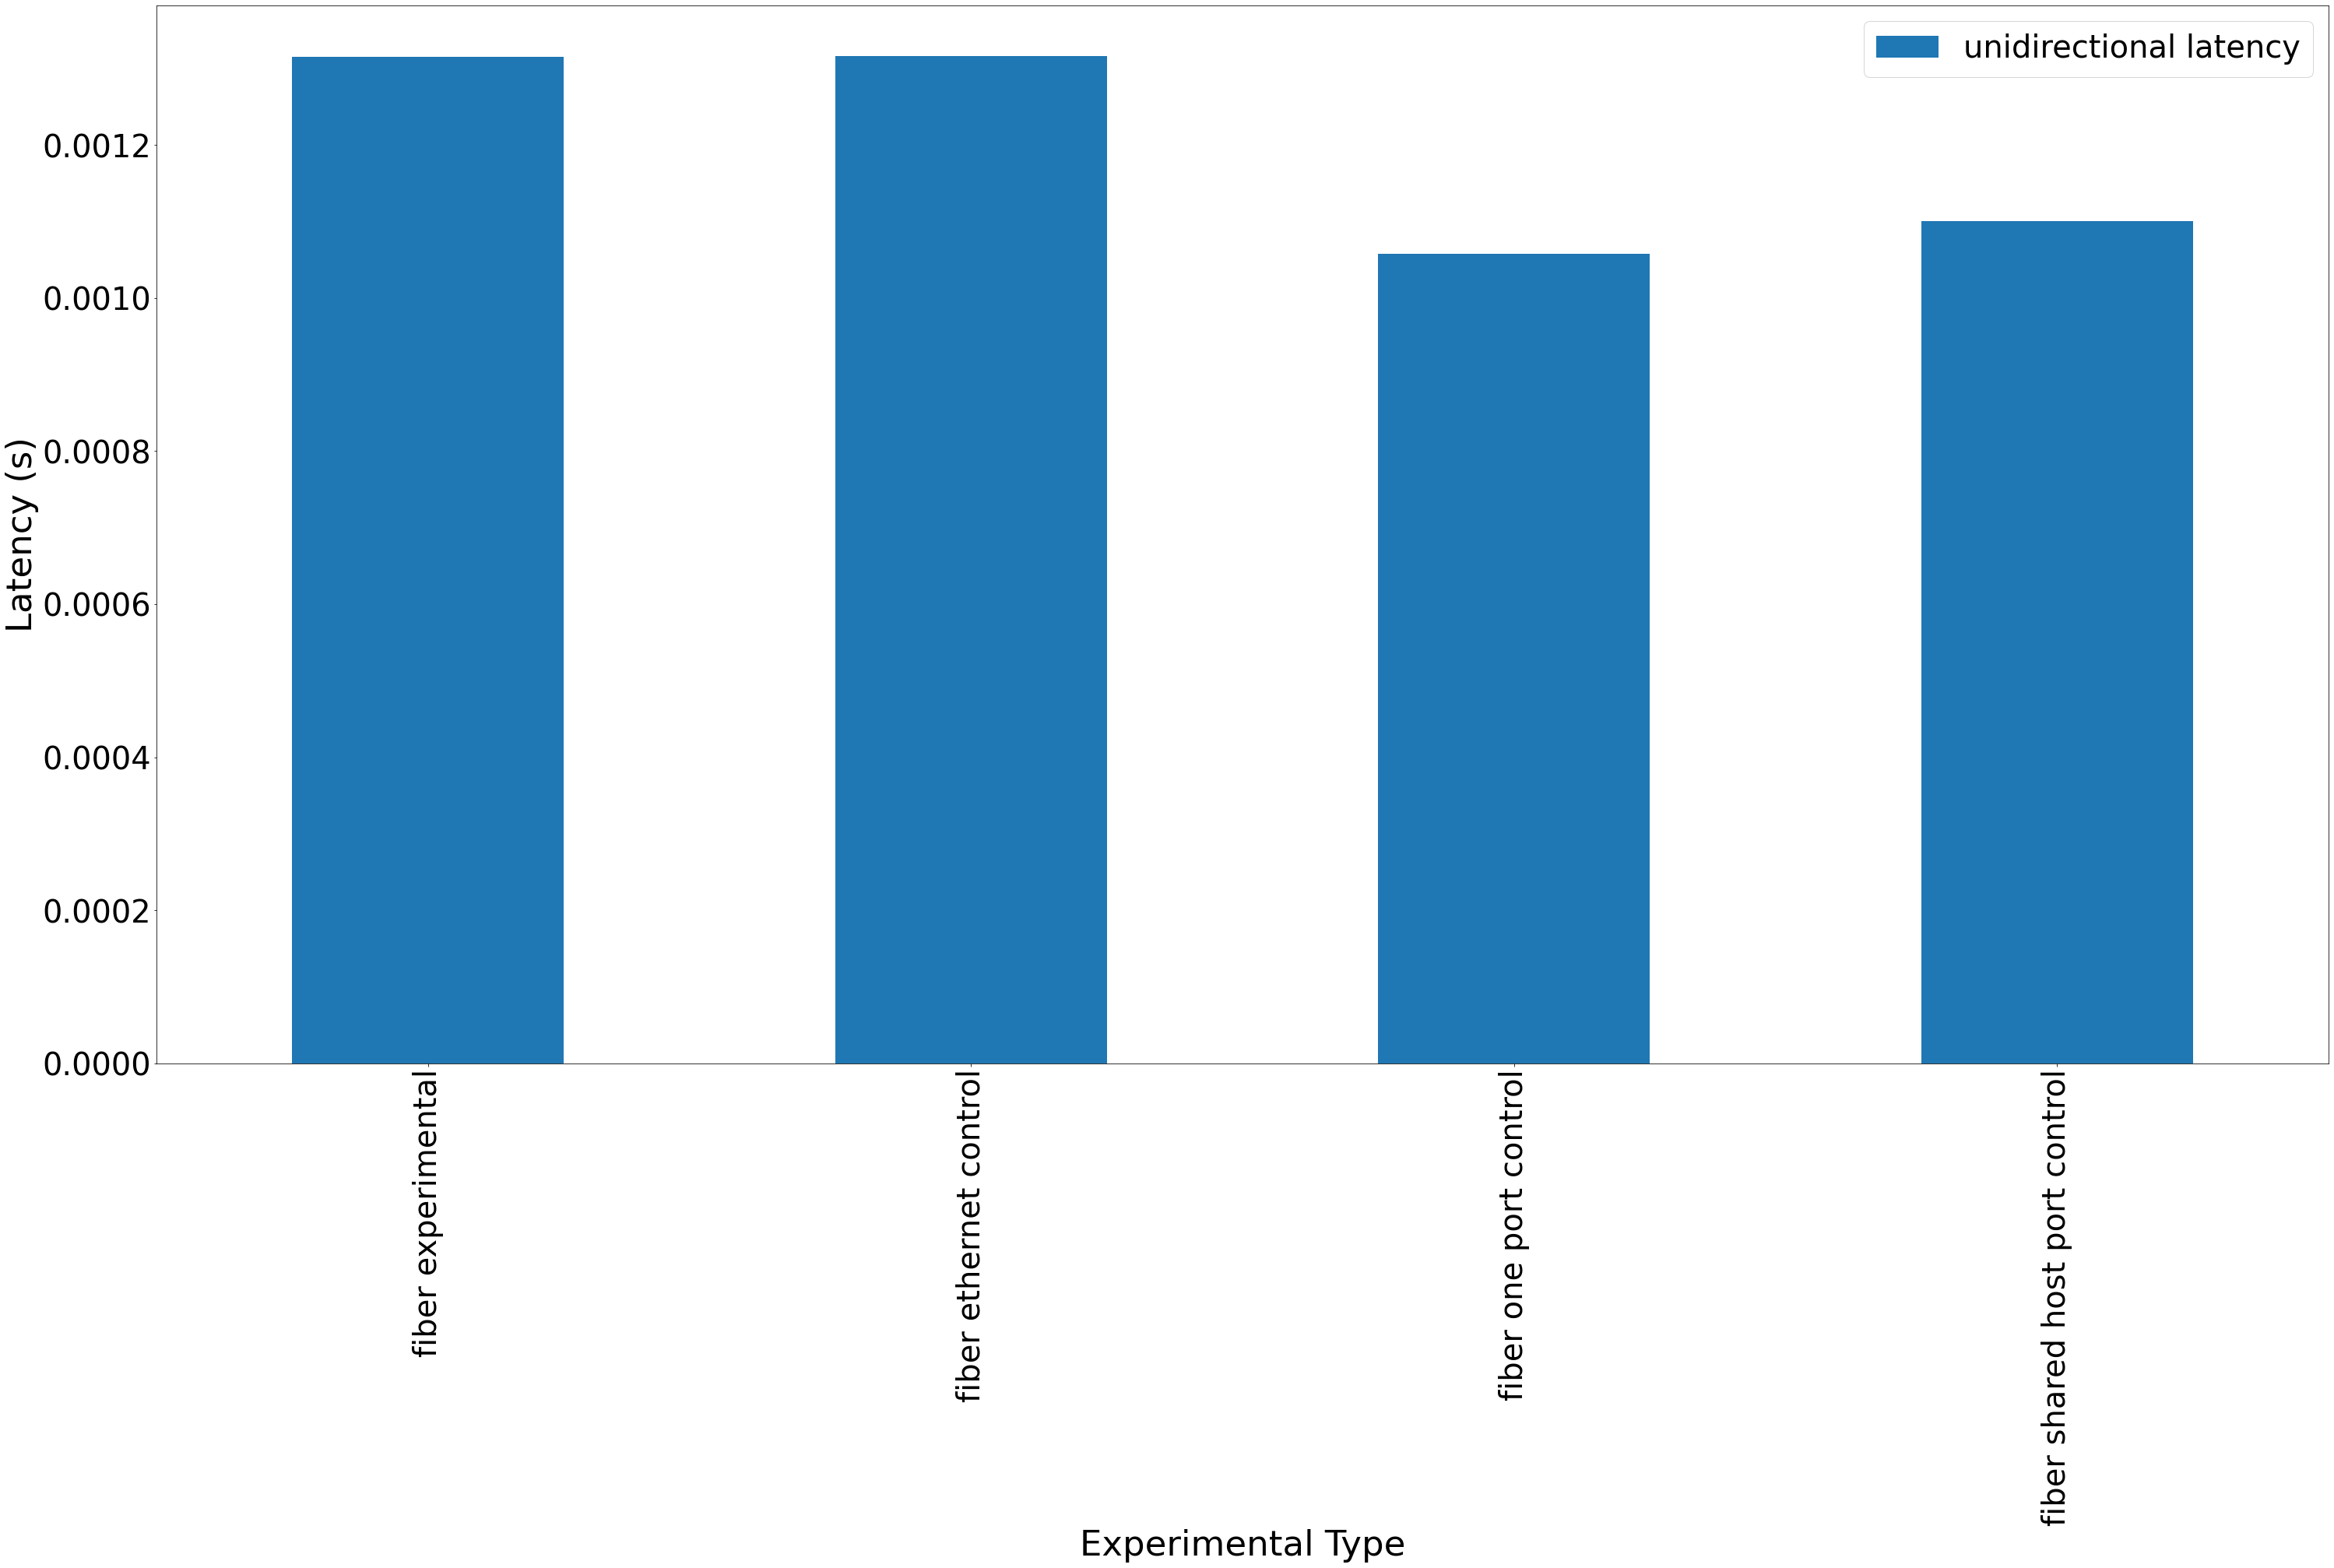

In [15]:
f = search_columns(latency_throughput_avg, 'latency').rename(lambda x: x.replace('_', ' ').replace('fiber ', ''), axis=1).rename(lambda x: x.replace('_', ' '), axis=0).plot(figsize=(50,25), lw=10, fontsize=40, xlabel='Experimental Setup', ylabel="Throughput (Gbps)", kind='bar', use_index=True)
f.set_ylabel('Latency (s)', fontdict={'fontsize': 45})
f.set_xlabel('Experimental Type', fontdict={'fontsize': 45})
f.legend(loc=0, fontsize=40)
f


# Error Rate

In [16]:
retransmits = pd.DataFrame({
    field: {
        'bidirectional_throughput': dd.from_pandas(pd.Series(), chunksize=chunksize).append(
                                        get_dd_of_paths(value, read_retransmits, 'bidirectional_throughput*.json')
                                    ).reset_index(drop=True),
        'parallel_throughput':dd.from_pandas(pd.Series(), chunksize=chunksize).append(
                                        get_dd_of_paths(value, read_retransmits, 'parallel_throughput*.json')
                                    ).reset_index(drop=True),
        'unidirectional_throughput':dd.from_pandas(pd.Series(), chunksize=chunksize).append(
                                        get_dd_of_paths(value, read_retransmits, 'unidirectional_throughput*.json')
                                    ).reset_index(drop=True),
    }
    
    for field, value in raw_data_paths.items()
}).T

/tmp/ipykernel_13471/619130890.py:3: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  'bidirectional_throughput': dd.from_pandas(pd.Series(), chunksize=chunksize).append(
/tmp/ipykernel_13471/3417018491.py:10: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  pd.Series().append([
/tmp/ipykernel_13471/619130890.py:6: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  'parallel_throughput':dd.from_pandas(pd.Series(), chunksize=chunksize).append(
/tmp/ipykernel_13471/3417018491.py:10: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this wa

In [17]:
bytes_sent = pd.DataFrame({
    field: {
        'bidirectional_throughput': dd.from_pandas(pd.Series(), chunksize=chunksize).append(
                                        get_dd_of_paths(value, read_bytes_sent, 'bidirectional_throughput*.json')
                                    ).reset_index(drop=True),
        'parallel_throughput':dd.from_pandas(pd.Series(), chunksize=chunksize).append(
                                        get_dd_of_paths(value, read_bytes_sent, 'parallel_throughput*.json')
                                    ).reset_index(drop=True),
        'unidirectional_throughput':dd.from_pandas(pd.Series(), chunksize=chunksize).append(
                                        get_dd_of_paths(value, read_bytes_sent, 'unidirectional_throughput*.json')
                                    ).reset_index(drop=True),
    }
    
    for field, value in raw_data_paths.items()
}).T

/tmp/ipykernel_13471/1042137995.py:3: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  'bidirectional_throughput': dd.from_pandas(pd.Series(), chunksize=chunksize).append(
/tmp/ipykernel_13471/3417018491.py:10: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  pd.Series().append([
/tmp/ipykernel_13471/1042137995.py:6: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  'parallel_throughput':dd.from_pandas(pd.Series(), chunksize=chunksize).append(
/tmp/ipykernel_13471/3417018491.py:10: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this 

In [18]:
err_average = average(retransmits)/average(bytes_sent)
err_average.to_csv('./results/error_averages.csv')

<AxesSubplot:xlabel='Experimental Type', ylabel='Error Rate (error per GB)'>

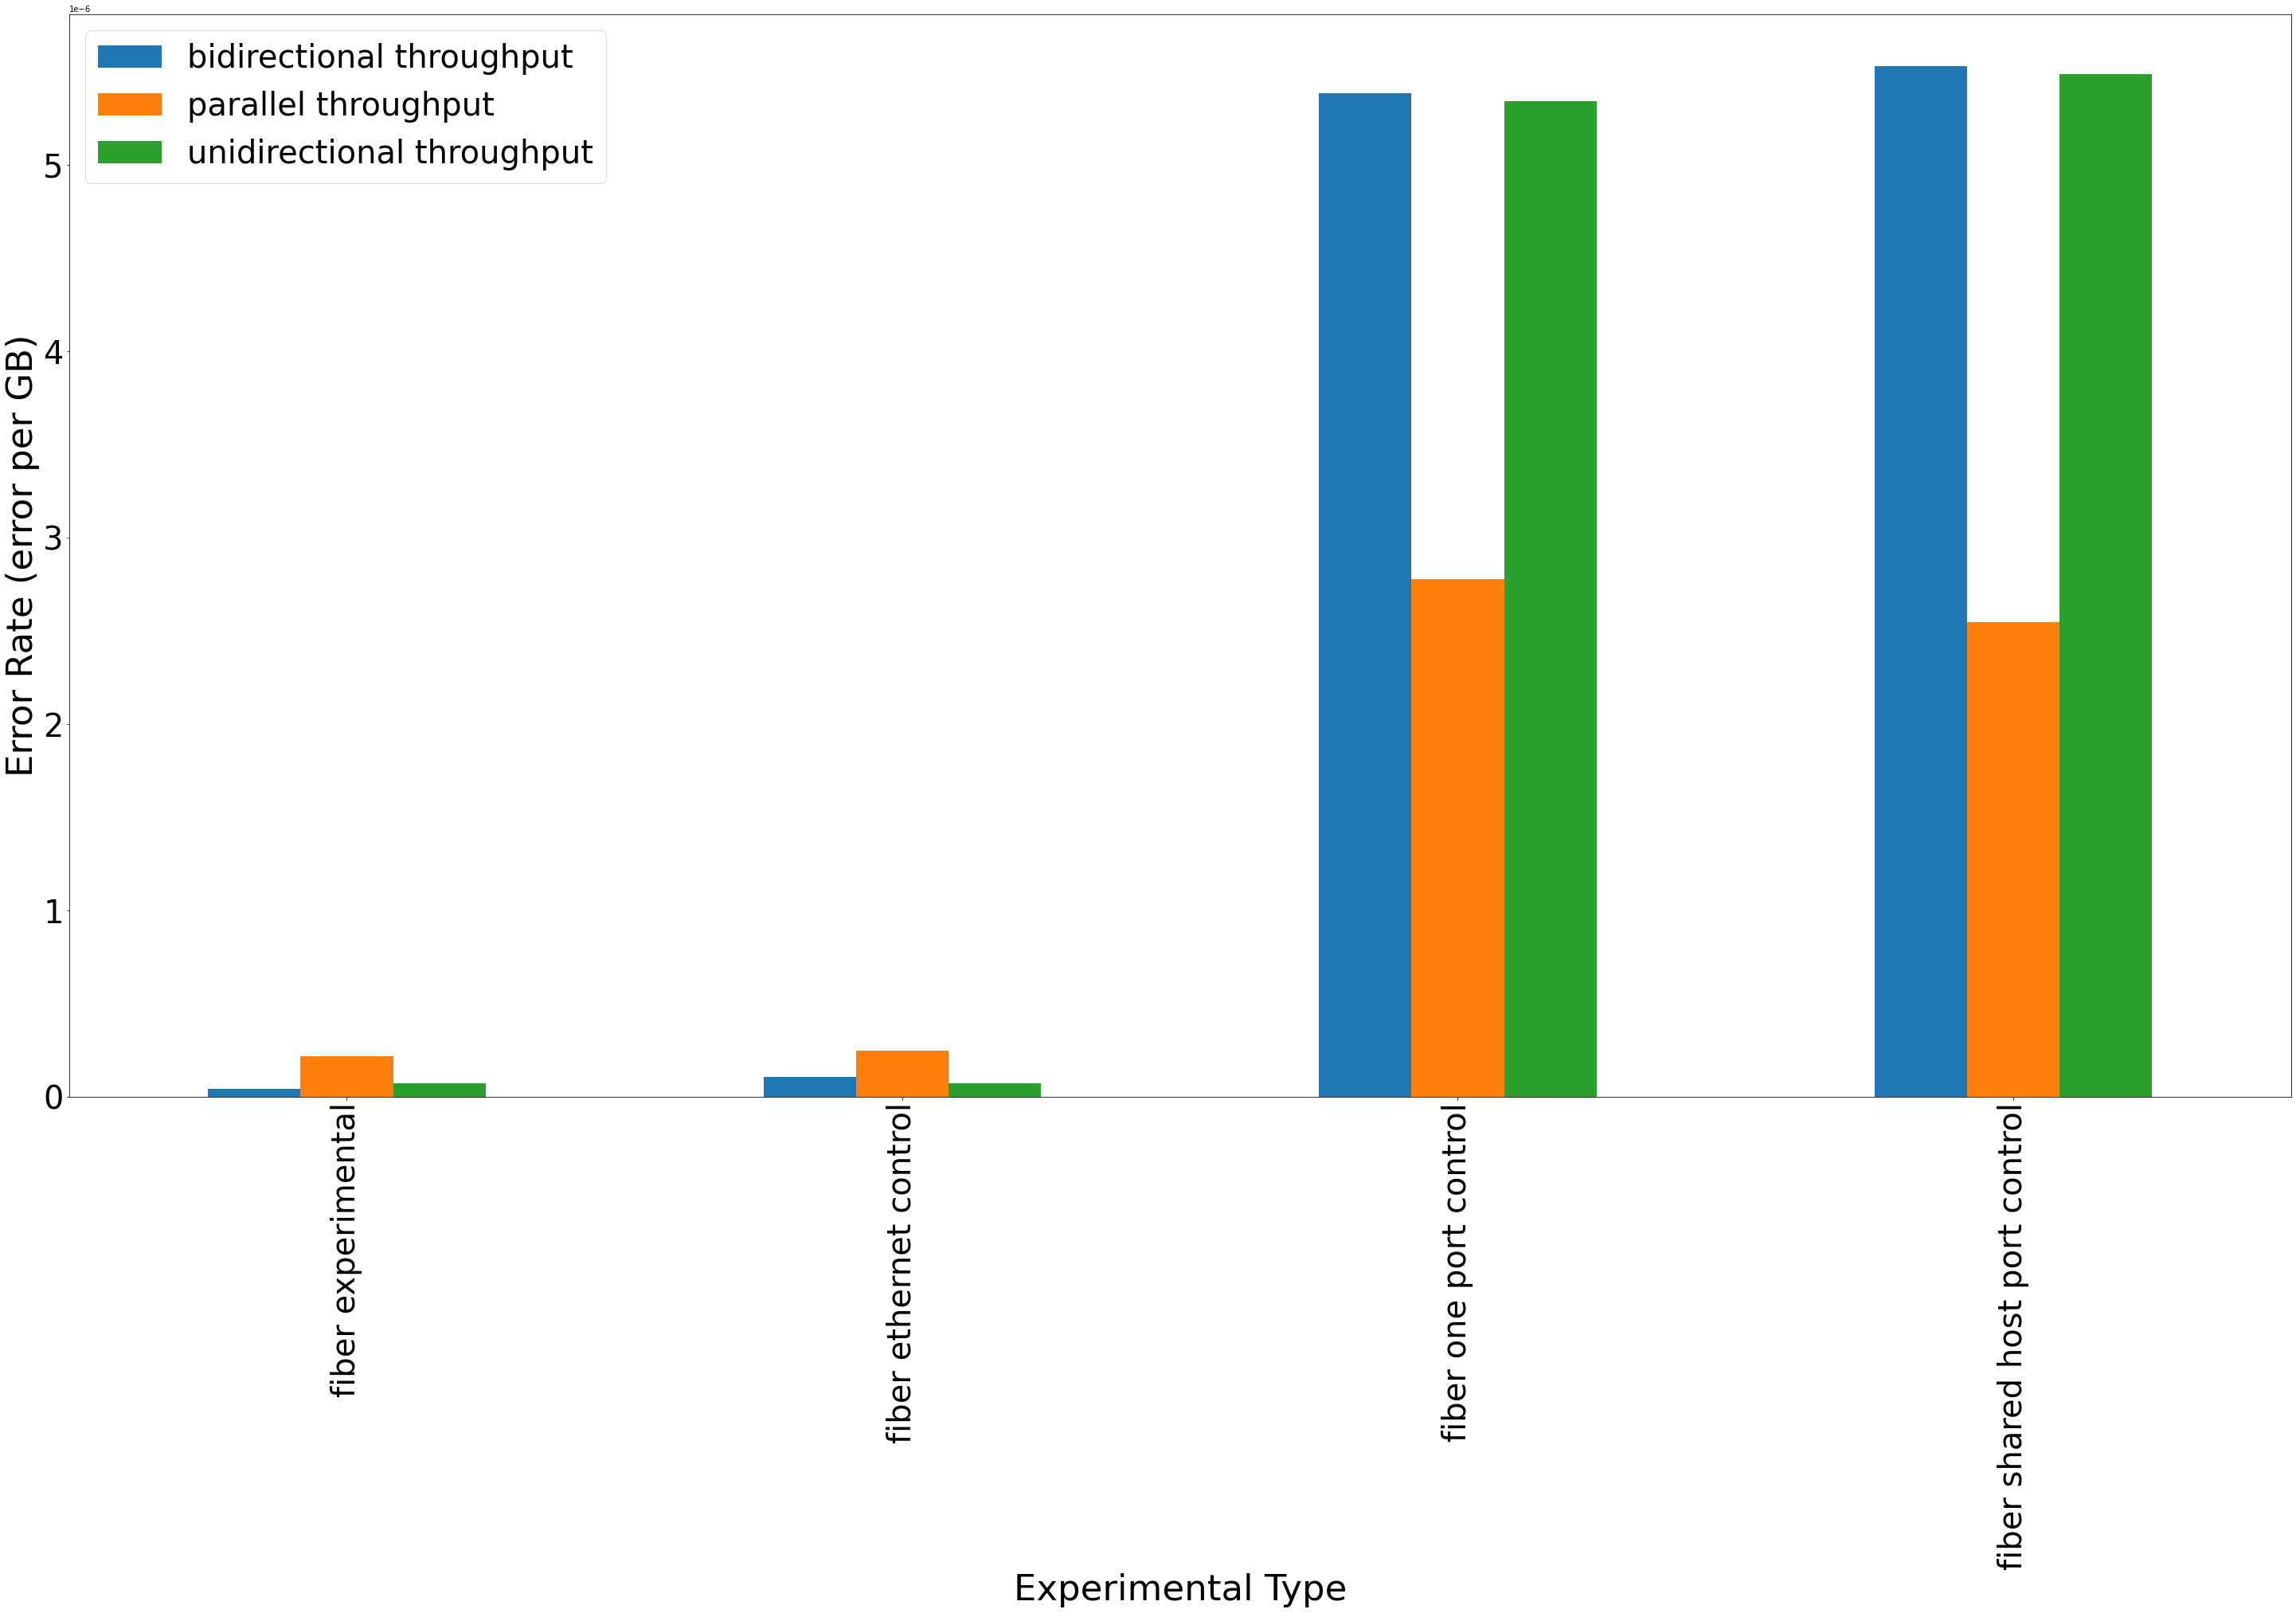

In [19]:
f = err_average.rename(lambda x: x.replace('_', ' ').replace('fiber ', ''), axis=1).rename(lambda x: x.replace('_', ' '), axis=0).plot(figsize=(50,25), lw=10, fontsize=40, xlabel='Experimental Setup', ylabel="Throughput (Gbps)", kind='bar', use_index=True)
f.set_ylabel('Error Rate (error per GB)', fontdict={'fontsize': 45})
f.set_xlabel('Experimental Type', fontdict={'fontsize': 45})
f.legend(loc=0, fontsize=40)
f
